In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [164]:
pp = pprint.PrettyPrinter(indent = 3)

In [165]:
df = pd.read_csv("supernova_dataset.csv")
print(df.shape)
df.head()

(9564, 26)


,kepid,koi_disposition,koi_period,koi_duration,koi_depth,koi_impact,koi_model_snr,koi_num_transits,koi_ror,koi_prad,...,teff_err1,teff_err2,logg_err1,logg_err2,feh_err1,feh_err2,mass_err1,mass_err2,radius_err1,radius_err2
0,10797460,CONFIRMED,9.488036,2.95750,615.8,0.146,35.8,142.0,0.022344,2.26,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
1,10797460,CONFIRMED,54.418383,4.50700,874.8,0.586,25.8,25.0,0.027954,2.83,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
2,10811496,CANDIDATE,19.899140,1.78220,10829.0,0.969,76.3,56.0,0.154046,14.60,...,158.0,-171.0,0.044,-0.176,0.26,-0.26,0.10375,-0.11465,0.237,-0.078
3,10848459,FALSE POSITIVE,1.736952,2.40641,8079.2,1.276,505.6,621.0,0.387394,33.46,...,157.0,-144.0,0.053,-0.223,0.30,-0.26,0.09995,-0.07165,0.364,-0.068
4,10854555,CONFIRMED,2.525592,1.65450,603.3,0.701,40.9,515.0,0.024064,2.75,...,151.0,-207.0,0.070,-0.222,0.17,-0.29,0.19050,-0.13700,0.442,-0.133


# Counting NaN Values

In [166]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}

In [167]:
pp.pprint(nan_columns)

{  'feh_err1': 109,
   'feh_err2': 109,
   'koi_depth': 363,
   'koi_impact': 363,
   'koi_model_snr': 363,
   'koi_num_transits': 1142,
   'koi_prad': 363,
   'koi_ror': 363,
   'logg_err1': 109,
   'logg_err2': 109,
   'mass_err1': 109,
   'mass_err2': 109,
   'radius_err1': 109,
   'radius_err2': 109,
   'st_dens': 109,
   'st_mass': 109,
   'teff_err1': 109,
   'teff_err2': 109}


## Preliminary Cleaning

### Removing Mostly NaN Rows

A threshold is set such that rows in which atleast **20%** of the fields are NaN are dropped.

In [168]:
df = df[~(df.isnull().sum(axis=1) > int((0.2)*df.shape[1]))]

In [169]:
print(df.shape)

(9202, 26)


The number of rows has decreased from 9564 to 9202

# Replacing NaN Values

There are two broad types of NaN values present.
* NaN in Error Values - These include the positive and negative error in estimating attributes
* NaN in Measurable Attributes - These include missing values in measuring attributes

## Replacing NaN in Error Values

### Finding Error Attributes with NaN

In [170]:
missing_error_attribute_names = [attr for attr in df.columns if "err" in attr]
pp.pprint(missing_error_attribute_names)

[  'teff_err1',
   'teff_err2',
   'logg_err1',
   'logg_err2',
   'feh_err1',
   'feh_err2',
   'mass_err1',
   'mass_err2',
   'radius_err1',
   'radius_err2']


the error columns are **effective temperature, surface gravity, metallicity, mass and radius** (of the stars)

Since these are positive and negative error measures for the corresponding attributes, we can do either of the following
* Replace with the mean or median of the attribute errors
* Drop the rows
* Replace with a default value = 0
* Take a look at the percentage error between the column and its associated error

We cannot use regression based techniques to estimate the error since
* A greater set of values does not mean a greater error
* The errors consist of errors while estimating a value and do not depend on any of the attributes

### Finding Distributions of Error Attributes

Let us first extract a slice of the dataset that contains the error attributes

In [171]:
missing_error_values_df = df[missing_error_attribute_names].copy()
print(missing_error_values_df.shape)
missing_error_values_df.head()

(9202, 10)


,teff_err1,teff_err2,logg_err1,logg_err2,feh_err1,feh_err2,mass_err1,mass_err2,radius_err1,radius_err2
0,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
1,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
2,158.0,-171.0,0.044,-0.176,0.26,-0.26,0.10375,-0.11465,0.237,-0.078
3,157.0,-144.0,0.053,-0.223,0.30,-0.26,0.09995,-0.07165,0.364,-0.068
4,151.0,-207.0,0.070,-0.222,0.17,-0.29,0.19050,-0.13700,0.442,-0.133


We can now find the mean and median of the remaining columns

In [172]:
error_attribute_means = np.nanmean(missing_error_values_df.values, axis=0)
error_attribute_means

array([ 1.43448000e+02, -1.57469898e+02,  1.12402521e-01, -1.73180178e-01,
        2.16326559e-01, -2.41341230e-01,  1.35677217e-01, -1.38586829e-01,
        4.27612747e-01, -3.54866279e-01])

In [173]:
error_attribute_medians = np.nanmedian(missing_error_values_df.values, axis=0)
error_attribute_medians

array([ 1.53e+02, -1.49e+02,  7.40e-02, -1.93e-01,  2.20e-01, -2.60e-01,
        1.15e-01, -9.79e-02,  3.56e-01, -1.14e-01])

There seems to be some difference in the median and mean values, suggesting skewed data for attributes.<br>
We might need to plot each and decide when we can take the mean or the median.

## Replacing NaN in Effective Temperature

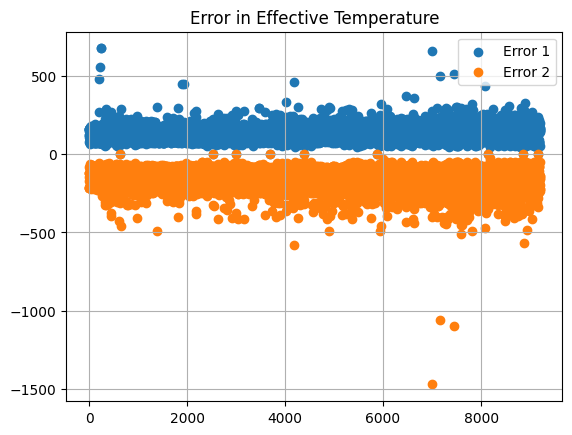

In [174]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["teff_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["teff_err2"].values, label = "Error 2")
plt.title("Error in Effective Temperature")
plt.grid()
plt.legend()
plt.show()

### Viewing Frequency Distribution

#### Positive Error

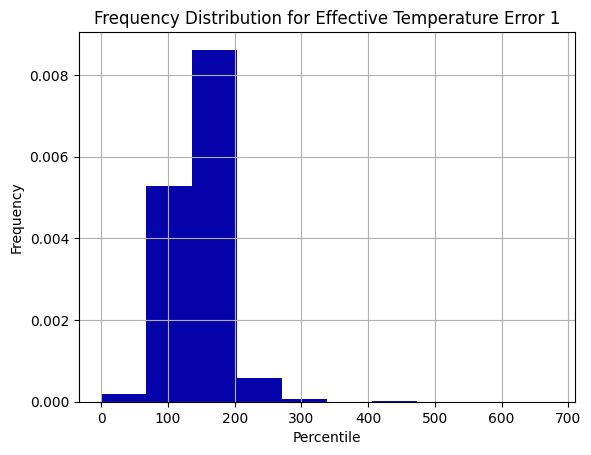

In [175]:
plt.hist(missing_error_values_df["teff_err1"].values, color = "#0504aa", density=True)
plt.title("Frequency Distribution for Effective Temperature Error 1")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.grid()

#### Negative Error

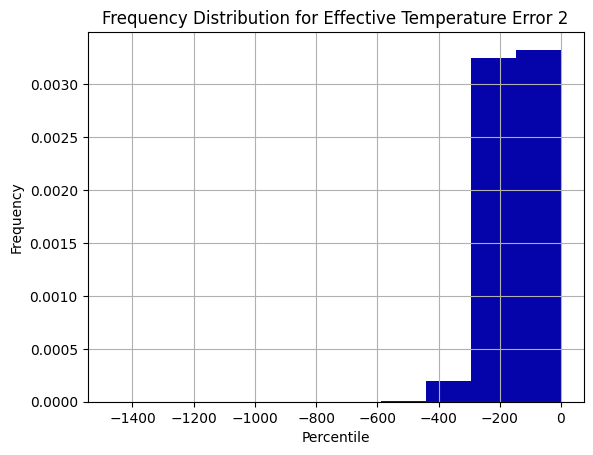

In [176]:
plt.hist(missing_error_values_df["teff_err2"].values, color="#0504aa", density = True)
plt.title("Frequency Distribution for Effective Temperature Error 2")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.grid()

## Replacing NaN in Surface Gravity

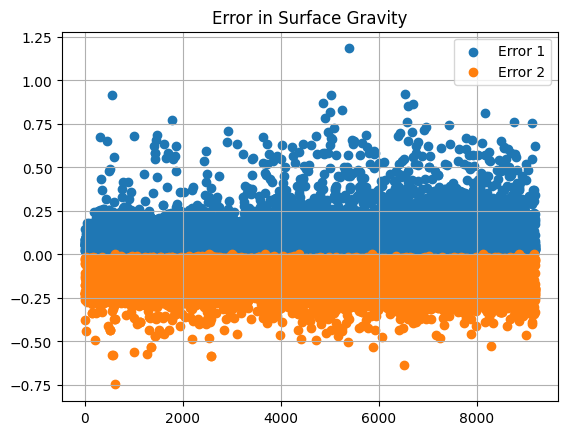

In [177]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["logg_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["logg_err2"].values, label = "Error 2")
plt.title("Error in Surface Gravity")
plt.legend()
plt.grid()

### Viewing Frequency Distribution

#### Positive Error

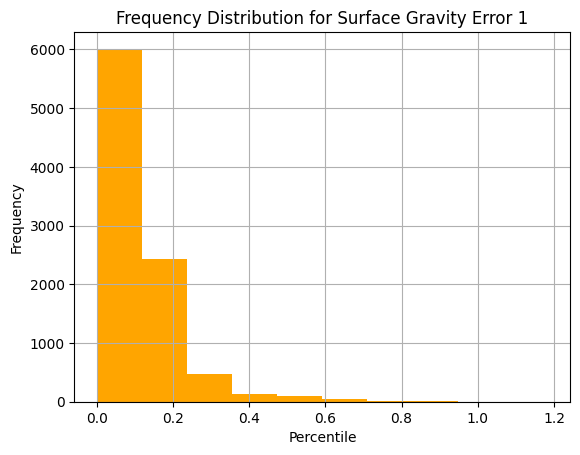

In [178]:
plt.hist(missing_error_values_df["logg_err1"].values, color="orange")
plt.title("Frequency Distribution for Surface Gravity Error 1")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.grid()

#### Negative Error

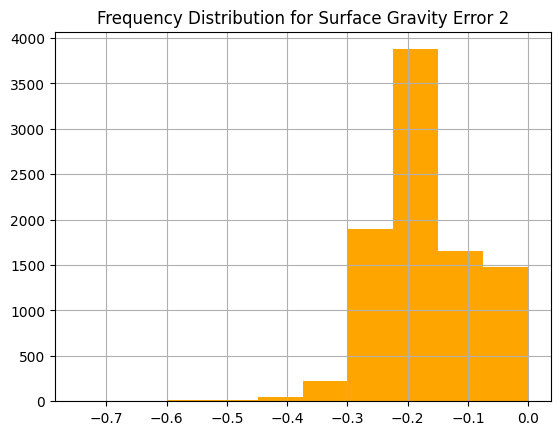

In [179]:
plt.hist(missing_error_values_df["logg_err2"].values, color="orange")
plt.title("Frequency Distribution for Surface Gravity Error 2")
plt.grid()

## Replacing NaN in Metallicity

### Viewing Frequency Distribution

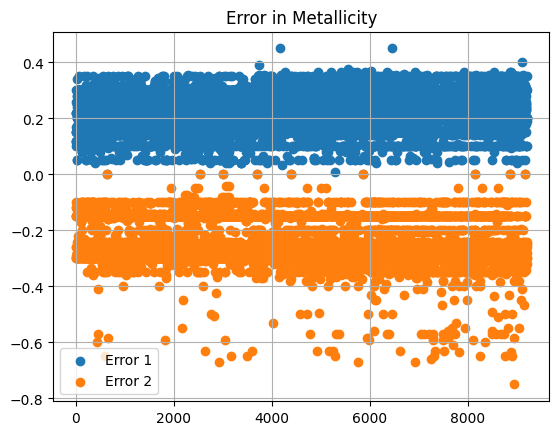

In [180]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["feh_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["feh_err2"].values, label = "Error 2")
plt.title("Error in Metallicity")
plt.legend()
plt.grid()

#### Positive Error

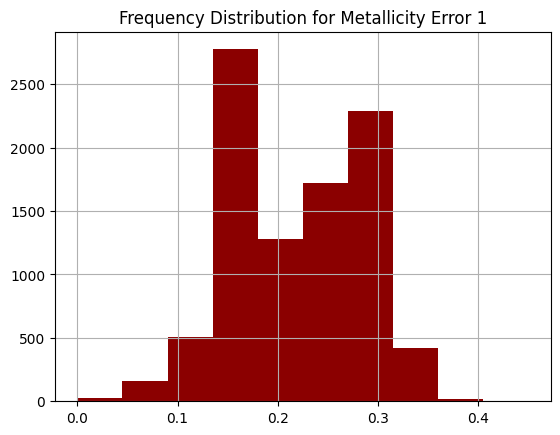

In [181]:
plt.hist(missing_error_values_df["feh_err1"].values, color="darkred")
plt.title("Frequency Distribution for Metallicity Error 1")
plt.grid()

#### Negative Error

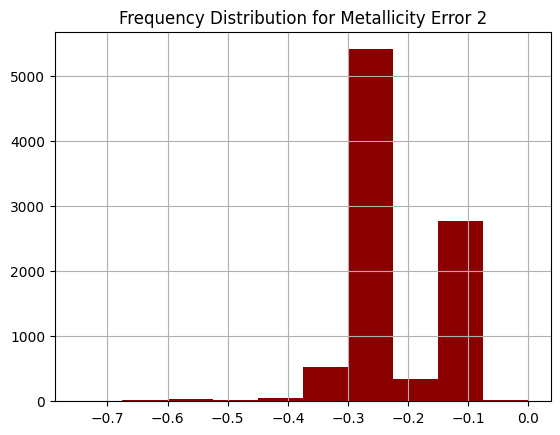

In [182]:
plt.hist(missing_error_values_df["feh_err2"].values, color="darkred")
plt.title("Frequency Distribution for Metallicity Error 2")
plt.grid()

## Replacing NaN in Star Mass

### Viewing Frequency Distribution

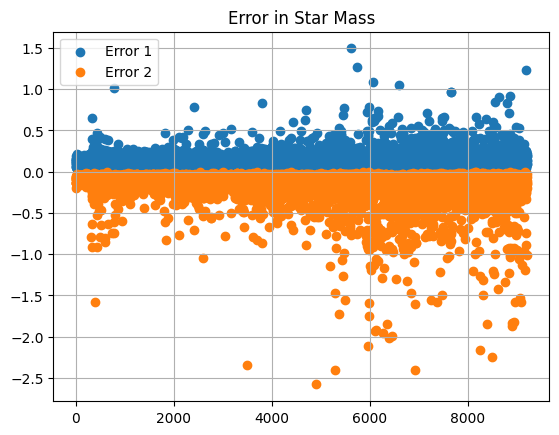

In [183]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["mass_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["mass_err2"].values, label = "Error 2")
plt.title("Error in Star Mass")
plt.legend()
plt.grid()

#### Positive Error

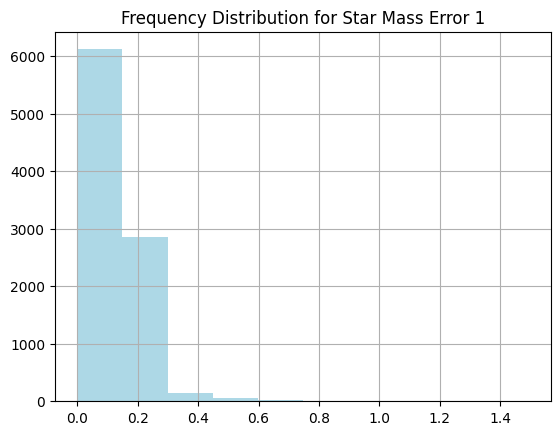

In [184]:
plt.hist(missing_error_values_df["mass_err1"].values, color="lightblue")
plt.title("Frequency Distribution for Star Mass Error 1")
plt.grid()

#### Negative Error

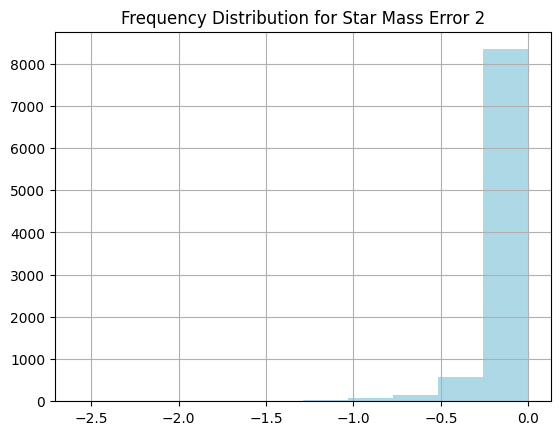

In [185]:
plt.hist(missing_error_values_df["mass_err2"].values, color="lightblue")
plt.title("Frequency Distribution for Star Mass Error 2")
plt.grid()

## Replacing NaN in Star Radius

### Viewing Frequency Distribution

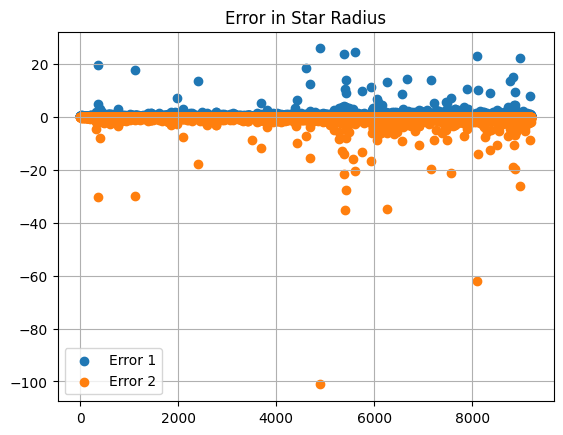

In [186]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["radius_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["radius_err2"].values, label = "Error 2")
plt.title("Error in Star Radius")
plt.legend()
plt.grid()

#### Positive Error

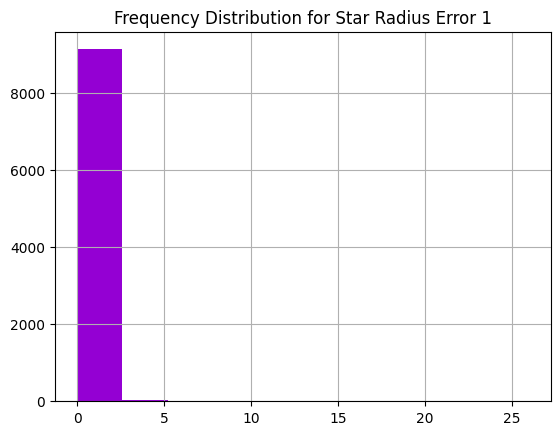

In [187]:
plt.hist(missing_error_values_df["radius_err1"].values, color="darkviolet")
plt.title("Frequency Distribution for Star Radius Error 1")
plt.grid()

#### Negative Error

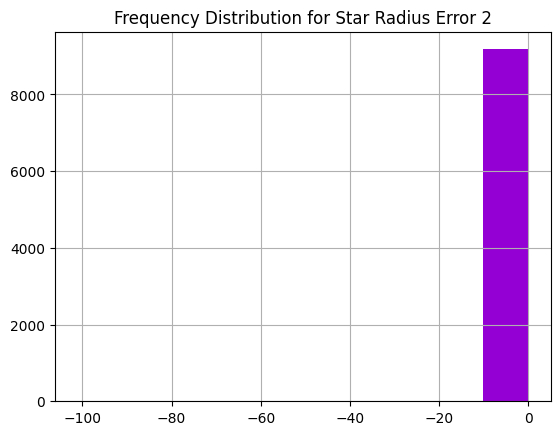

In [188]:
plt.hist(missing_error_values_df["radius_err2"].values, color="darkviolet")
plt.title("Frequency Distribution for Star Radius Error 2")
plt.grid()

In [189]:
df[missing_error_attribute_names] = (
    df[missing_error_attribute_names]
    .fillna(df[missing_error_attribute_names].median())
)

## Finding Errors in Non-Error Attributes

In [190]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}
pp.pprint(nan_columns)

{  'koi_depth': 105,
   'koi_impact': 105,
   'koi_model_snr': 105,
   'koi_num_transits': 874,
   'koi_prad': 105,
   'koi_ror': 105}


## Replacing NaN in Transit Depth

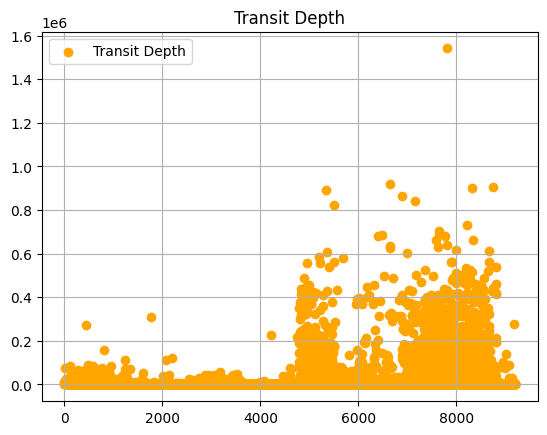

In [191]:
plt.scatter(range(df.shape[0]), df["koi_depth"].values, label = "Transit Depth", color ="orange")
plt.title("Transit Depth")
plt.legend()
plt.grid()

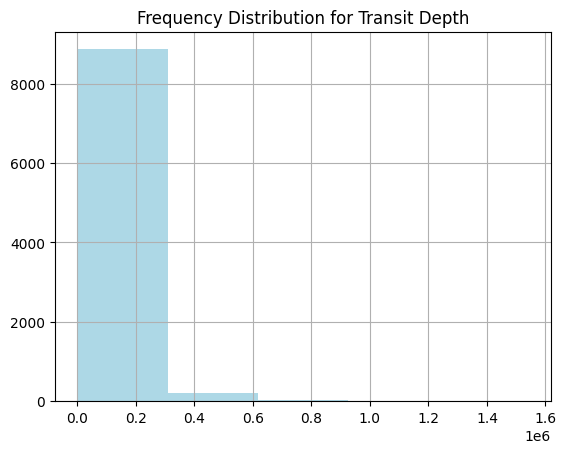

In [192]:
plt.hist(df["koi_depth"].values, bins=5, color="lightblue")
plt.title("Frequency Distribution for Transit Depth")
plt.grid()

## Replacing NaN in Impact Parameter

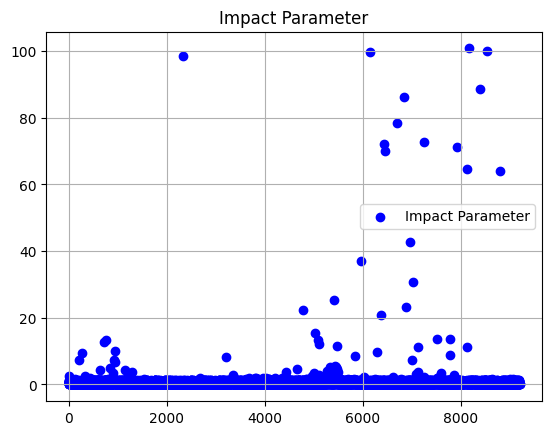

In [193]:
plt.scatter(range(df.shape[0]), df["koi_impact"].values, label = "Impact Parameter", color="blue")
plt.title("Impact Parameter")
plt.legend()
plt.grid()

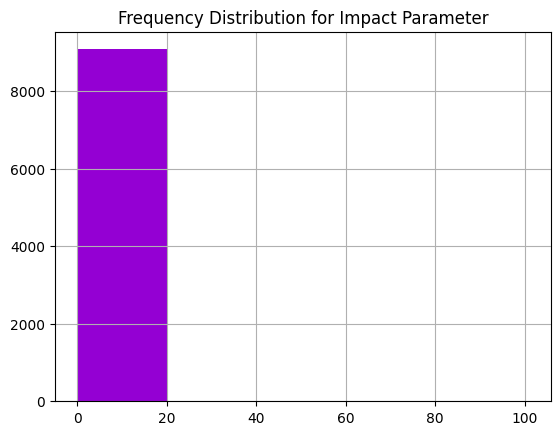

In [194]:
plt.hist(df["koi_impact"].values, bins=5, color="darkviolet")
plt.title("Frequency Distribution for Impact Parameter")
plt.grid()

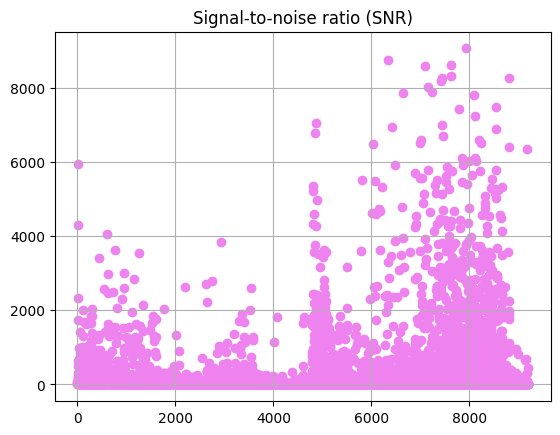

In [195]:
plt.scatter(range(df.shape[0]), df["koi_model_snr"].values, label = "SNR", color="violet")
plt.title("Signal-to-noise ratio (SNR)")
plt.grid()

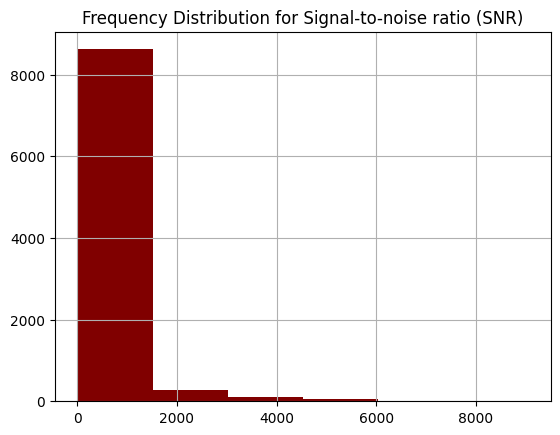

In [196]:
plt.hist(df["koi_model_snr"].values, color="maroon", bins=6)
plt.title("Frequency Distribution for Signal-to-noise ratio (SNR)")
plt.grid()

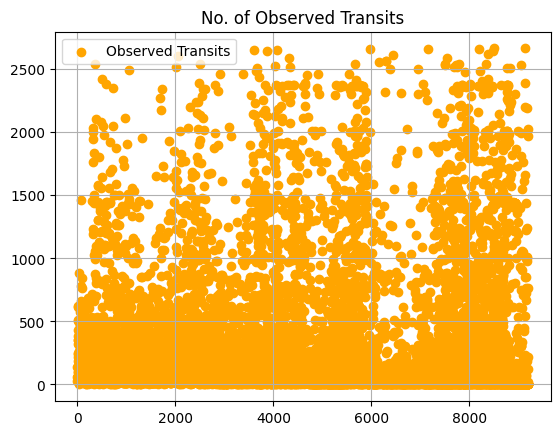

In [197]:
plt.scatter(range(df.shape[0]), df["koi_num_transits"].values, label = "Observed Transits", color="orange")
plt.title("No. of Observed Transits")
plt.legend()
plt.grid()

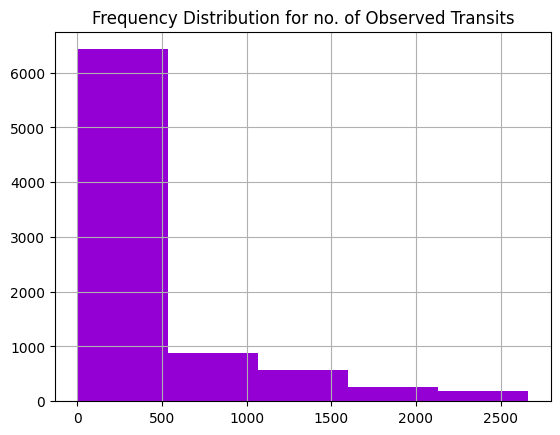

In [198]:
plt.hist(df["koi_num_transits"].values, bins=5, color="darkviolet")
plt.title("Frequency Distribution for no. of Observed Transits")
plt.grid()

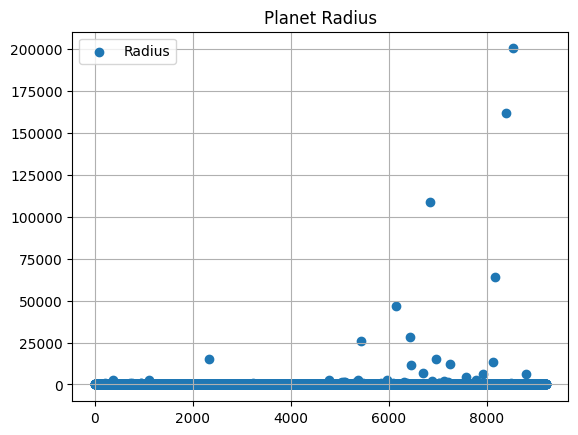

In [199]:
plt.scatter(range(df.shape[0]), df["koi_prad"].values, label = "Radius")
plt.title("Planet Radius")
plt.legend()
plt.grid()

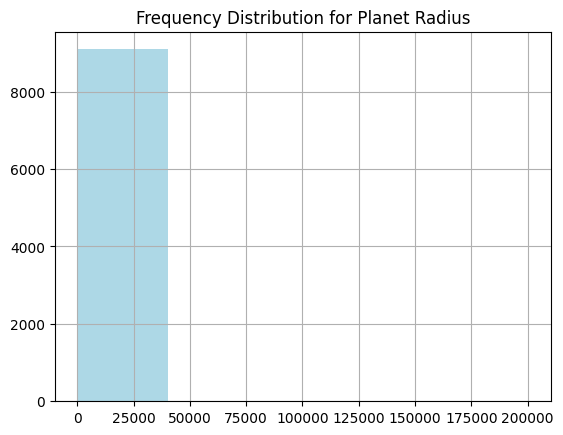

In [200]:
plt.hist(df["koi_prad"].values, color="lightblue", bins = 5)
plt.title("Frequency Distribution for Planet Radius")
plt.grid()

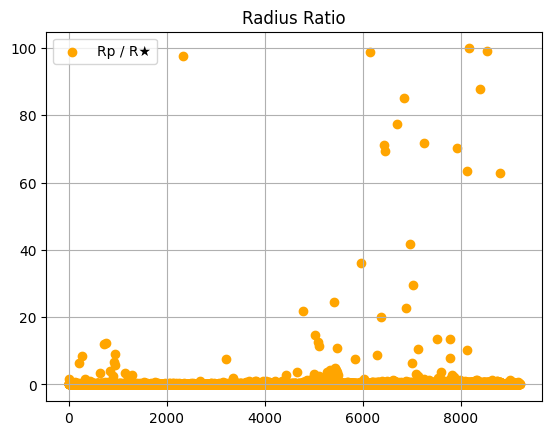

In [201]:
plt.scatter(range(df.shape[0]), df["koi_ror"].values, label = "Rp / R★", color="orange")
plt.title("Radius Ratio")
plt.legend()
plt.grid()

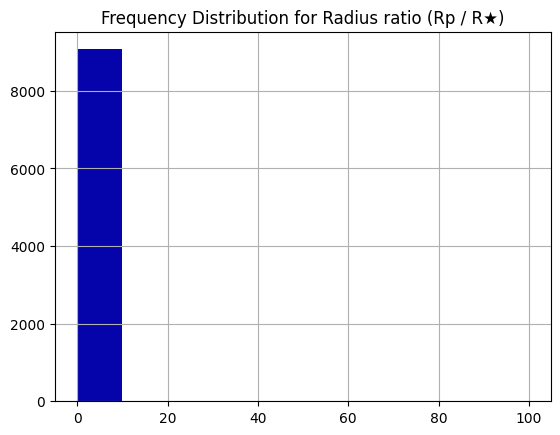

In [202]:
plt.hist(df["koi_ror"].values, color="#0504aa")
plt.title("Frequency Distribution for Radius ratio (Rp / R★)")
plt.grid()

In [203]:
cols = [
    "koi_depth",
    "koi_impact",
    "koi_model_snr",
    "koi_num_transits",
    "koi_prad",
    "koi_ror",
]

df[cols] = df[cols].fillna(df[cols].median())

In [204]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}
pp.pprint(nan_columns)

{}


In [205]:
df.to_csv("[CLEANED]supernova-dataset.csv")

# Visualization

In [206]:
import plotly.express as px
import pandas as pd
df = pd.read_csv("[CLEANED]supernova-dataset.csv")
print(df.shape)
df.head()

(9202, 27)


,Unnamed: 0,kepid,koi_disposition,koi_period,koi_duration,koi_depth,koi_impact,koi_model_snr,koi_num_transits,koi_ror,...,teff_err1,teff_err2,logg_err1,logg_err2,feh_err1,feh_err2,mass_err1,mass_err2,radius_err1,radius_err2
0,0,10797460,CONFIRMED,9.488036,2.95750,615.8,0.146,35.8,142.0,0.022344,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
1,1,10797460,CONFIRMED,54.418383,4.50700,874.8,0.586,25.8,25.0,0.027954,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
2,2,10811496,CANDIDATE,19.899140,1.78220,10829.0,0.969,76.3,56.0,0.154046,...,158.0,-171.0,0.044,-0.176,0.26,-0.26,0.10375,-0.11465,0.237,-0.078
3,3,10848459,FALSE POSITIVE,1.736952,2.40641,8079.2,1.276,505.6,621.0,0.387394,...,157.0,-144.0,0.053,-0.223,0.30,-0.26,0.09995,-0.07165,0.364,-0.068
4,4,10854555,CONFIRMED,2.525592,1.65450,603.3,0.701,40.9,515.0,0.024064,...,151.0,-207.0,0.070,-0.222,0.17,-0.29,0.19050,-0.13700,0.442,-0.133


### disposition

In [207]:
px.histogram(df, x="koi_disposition")

### planet properties

In [208]:
(df["koi_prad"] <= 0).sum()

np.int64(0)

In [223]:
px.histogram(df, x="koi_prad", color="koi_disposition")

In [212]:
px.histogram(df, x="koi_period", color="koi_disposition", log_x=True)

In [213]:
px.scatter(df, x="koi_period", y="koi_prad", color="koi_disposition")

In [214]:
px.scatter(df, x="koi_depth", y="koi_prad", color="koi_disposition")

In [215]:
px.scatter(df, x="koi_model_snr", y="koi_num_transits", color="koi_disposition")

### star properties

In [216]:
px.histogram(df, x="st_teff", color="koi_disposition")

In [217]:
px.histogram(df, x="st_radius", color="koi_disposition")

In [218]:
px.scatter(df, x="st_teff", y="koi_prad", color="koi_disposition")

In [219]:
px.scatter(df, x="st_radius", y="koi_period", color="koi_disposition")